In [29]:
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import pandas as pd
import numpy as np
import torch
from torch import nn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse

In [30]:
class BostonDataset(Dataset):
    def __init__(self, X, y, device, to_scale=True, scaler=StandardScaler):
        if to_scale:
            scaler = scaler()
            X = scaler.fit_transform(X)
            y = scaler.fit_transform(y)

        self.X = torch.tensor(X, device=device)
        self.y = torch.tensor(y, device=device)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx].float(), self.y[idx].float()

In [31]:
class FNN(nn.Module):
    def __init__(self):
        super(FNN, self).__init__()
        self.losses = {}
        self.accuracies = {}
        self.iterations = 0
        
        self.fc1 = nn.Linear(13, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        
    def forward(self, x):
        output = F.relu(self.fc1(x))
        output = F.relu(self.fc2(output))
        output = F.dropout(output, p=0.1)
        output = self.fc3(output)
        return output
    
    def fit(self, optimizer, loss_criterion, train_dataloader):
        self.train()
       
        self.iterations += 1
        epoch_loss = []
        
        for batch in train_dataloader:
            X, y = batch
            
            outputs = self.forward(X)
            loss = loss_criterion(outputs, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            epoch_loss.append(loss.item())
               
        self.losses[self.iterations] = np.mean(epoch_loss)
   
    def validate(self, val_dataloader, loss_criterion):
        self.eval()
        
        batch_losses = []
        with torch.no_grad():
            for batch in val_dataloader:
                X, y = batch
   
                outputs = self.forward(X)
                loss = loss_criterion(outputs, y)
                
                batch_losses.append(loss.item())
                 
            accuracy = np.mean(batch_losses)
            self.accuracies[self.iterations] = accuracy
        return accuracy
        
    def predict(self, x):
        with torch.no_grad():
            output = self.forward(x)  
        return output

In [32]:
def load_data(dataset, batch_size=8, train_size=0.8, test_size=0.1, val_size=0.1):
    
    dataset_len = len(dataset)
    train_idx = int(train_size * dataset_len)
    test_idx =int(test_size * dataset_len)
    val_idx = int(val_size * dataset_len)

    train_set = Subset(dataset, np.arange(0, train_idx))
    test_set = Subset(dataset, np.arange(train_idx, train_idx + test_idx))
    val_set = Subset(dataset, np.arange(train_idx + test_idx, train_idx + test_idx + val_idx))
    
    train_dataloader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=True, num_workers=0)
    test_dataloader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True, num_workers=0)
    
    return {
        'train': train_dataloader,
        'test': val_dataloader,
        'val': test_dataloader,
        'dataset': dataset
    }

In [33]:
def train_and_save(train_dataloader, val_dataloader, n_epochs, loss_criterion, opt, learning_rate, device, model_path=None, load_model=False):
    if load_model:
        model = torch.load(model_path)
    else:
        model = FNN()
        
    model.to(device)
        
    loss_criterion = loss_criterion()
    optimizer = opt(model.parameters(), lr=learning_rate)

    best_epoch = 0
    best_accuracy = np.inf
    
    not_improving = 0
    
    for epoch in range(1, n_epochs + 1):
        model.fit(optimizer=optimizer, loss_criterion=loss_criterion, train_dataloader=train_dataloader)
        accuracy = model.validate(val_dataloader=val_dataloader, loss_criterion=loss_criterion)
        
        print(f"Epoch[{epoch}/{n_epochs}]: Iteration: {model.iterations}, Training loss: {model.losses[model.iterations]}, Validation loss: {model.accuracies[model.iterations]}")
        
        if best_accuracy < accuracy:
            not_improving += 1
        else:
            not_improving = 0
            
        if best_accuracy > accuracy:
            best_epoch = epoch 
            best_accuracy = accuracy
            torch.save(model.state_dict(), './best_regression_model.pth')
            
        if not_improving == 3:
            print(f"Val loss did not improve the last 3 epochs - Stopped at epoch : {epoch}")
            print(f"Best epoch : {best_epoch}")
            break
    
    return model

In [34]:
def plot_test_model(y_true, y_pred, title):
    data = sorted(zip(y_true, y_pred), key= lambda x: x[1])
    plt.figure(figsize = (15,7))
    plt.title(title)
    plt.scatter([i for i in range(len(data))], [i[0] for i in data], color="red", label="Predictions")
    plt.plot([i for i in range(len(data))],[i[1] for i in data], color='green', label="Targets", marker='o')
    plt.legend()
    plt.show()

In [35]:
def load_model(base_model, model_path):
    model = base_model()
    model.load_state_dict(torch.load(model_path))
    return model

In [36]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

boston_df = pd.read_csv('./data/boston_train.csv')
boston_df.drop('ID', axis=1, inplace=True)

y = pd.DataFrame(boston_df['medv']).values
X = boston_df.drop('medv', axis=1).values

torch.manual_seed(0)

boston_set = BostonDataset(X, y, device)

dataloaders = load_data(boston_set, batch_size=8, train_size=0.8, test_size=0.1, val_size=0.1)

train_dataloader = dataloaders['train']
val_dataloader = dataloaders['val']
test_dataloader = dataloaders['test']

loss_criterion = nn.MSELoss
optimizer = torch.optim.Adam
learning_rate = 0.0001
n_epochs = 30

print(f'Train size : {len(train_dataloader.dataset)}')
print(f'Test size : {len(test_dataloader.dataset)}')
print(f'Val size : {len(val_dataloader.dataset)}')

model = train_and_save(train_dataloader=train_dataloader,
                       val_dataloader=val_dataloader, 
                       n_epochs=n_epochs,
                       loss_criterion=loss_criterion,
                       opt=optimizer,
                       learning_rate=learning_rate,
                       device=device)

Train size : 266
Test size : 33
Val size : 33
Epoch[1/30]: Iteration: 1, Training loss: 1.0370462747181164, Validation loss: 1.4718770742416383
Epoch[2/30]: Iteration: 2, Training loss: 0.9702874926083228, Validation loss: 1.2891758561134339
Epoch[3/30]: Iteration: 3, Training loss: 0.9731359459898051, Validation loss: 1.3854115962982179
Epoch[4/30]: Iteration: 4, Training loss: 0.9292686905931024, Validation loss: 1.1978774309158324
Epoch[5/30]: Iteration: 5, Training loss: 0.9361093605265898, Validation loss: 1.2507553815841674
Epoch[6/30]: Iteration: 6, Training loss: 0.8986732045955518, Validation loss: 1.0682825565338134
Epoch[7/30]: Iteration: 7, Training loss: 0.8747830544324482, Validation loss: 0.9140704691410064
Epoch[8/30]: Iteration: 8, Training loss: 0.87449715921984, Validation loss: 1.273021638393402
Epoch[9/30]: Iteration: 9, Training loss: 0.8335802841055042, Validation loss: 0.8556108593940734
Epoch[10/30]: Iteration: 10, Training loss: 0.8379344992777881, Validation 

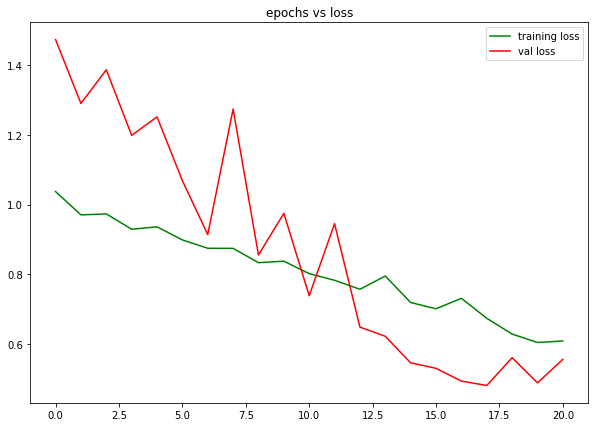

In [37]:
plt.figure(figsize = (10,7))
plt.title("epochs vs loss")
plt.plot([i for i in range(len(model.losses.values()))], list(model.losses.values()), c = 'green', label = 'training loss')
plt.plot([i for i in range(len(model.accuracies.values()))], list(model.accuracies.values()), c = 'red', label = 'val loss')
plt.legend()
plt.show()

In [41]:
best_model = load_model(FNN, 'best_regression_model.pth')

In [42]:
test_y_pred = []
test_y_true = []
for batch in test_dataloader:
    X, y = batch
    prediction = best_model.predict(X)
    test_y_pred.extend(prediction)
    test_y_true.extend(y)

y_pred = [i.item() for i in test_y_pred]
y_true = [i.item() for i in test_y_true]

val_y_pred = []
val_y_true = []
for batch in val_dataloader:
    X, y = batch
    prediction = best_model.predict(X)
    val_y_pred.extend(prediction)
    val_y_true.extend(y)

val_y_pred = [i.item() for i in val_y_pred]
val_y_true = [i.item() for i in val_y_true]


c:\Github\applied-ai\venv\lib\site-packages\numpy\ma\core.py:2829: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Github\applied-ai\venv\lib\site-packages\numpy\ma\core.py:2829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Github\applied-ai\venv\lib\site-packages\nump

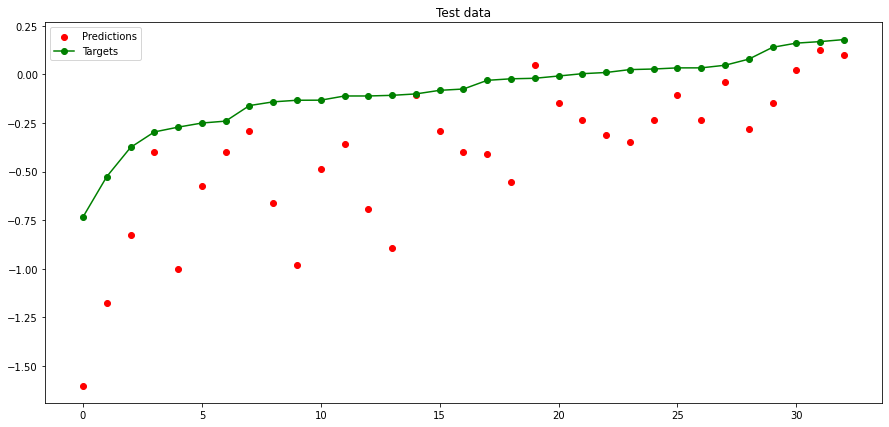

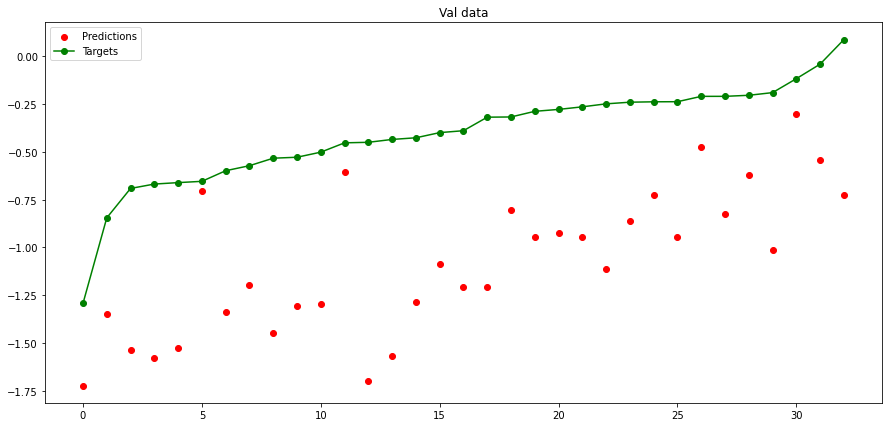

Test mse score: 0.16704012818619454
Val mse score: 0.5137313871830613


c:\Github\applied-ai\venv\lib\site-packages\sklearn\utils\validation.py:746: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = np.asarray(array, order=order, dtype=dtype)
c:\Github\applied-ai\venv\lib\site-packages\sklearn\utils\validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
c:\Github\applied-

In [43]:
plot_test_model(test_y_true, test_y_pred, 'Test data')
plot_test_model(val_y_true, val_y_pred, 'Val data')

test_mse_score = mse(test_y_true, test_y_pred)
val_mse_score = mse(val_y_true, val_y_pred)

print(f"Test mse score: {test_mse_score}")
print(f"Val mse score: {val_mse_score}")

plt.show()